## Chapter 5: Linear Models and Regularization - Lab

In [ ]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
(Stepwise,
sklearn_selected,
sklearn_selection_path)
!pip install l0bnb
from l0bnb import fit_path

### Forward Selection

We apply forward-selection to the `Hitters` data. We wish to predict a baseball player’s `Salary` on the basis of various statistics associated with performance in the previous year.

In [3]:
Hitters = load_data('Hitters')
np.isnan(Hitters['Salary']).sum()

59

In [4]:
Hitters = Hitters.dropna()

We first choose the best model using forward selection based on Cp. This score is not built into `sklearn`, so we define a function to compute it ourselves:

In [5]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / 2

We need to stimate the residual variance, which is the first argument to the function. we git the biggest model using all variables and estimate the variance based on its MSE.

In [8]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y, X).fit().scale

`sklean_selected()` expects a scorer with just three arguments (the last three in the definition of `nCp()`), so we define a partial to free the first argument:

In [13]:
neg_Cp = partial(nCp, sigma2)

We also need to define a search strategy. We do this using the `Stepwise()` object in the `ISLP.models` package. `Stepwise.first_peak()` runs forward stepwise until any further additions to the model do not result in an improvement in the evaluation score.

In [16]:
strategy = Stepwise.first_peak(design,
                              direction='forward',
                              max_terms=len(design.terms))

In [17]:
strategy

Strategy(initial_state=(), candidate_states=<bound method Stepwise.candidate_states of <ISLP.models.strategy.Stepwise object at 0x000001DC6812A7A0>>, build_submodel=<bound method ModelSpec.build_submodel of ModelSpec(terms=Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object'))>, check_finished=<function first_peak at 0x000001DC659AD000>, postprocess=<function _postprocess_best at 0x000001DC659AD240>)

We fit a linear regression model with `Salary` as the outcome using forward selection.

In [18]:
hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

Using `neg_Cp` results in a smaller model, as expected, with just 10 variables selected.

In [19]:
hitters_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

#### Choosing amoung models using the valifation set approach and cross-validation

As an alternative to using Cp, we might try cross-validation to select a model in forward selection.

For this, we need a method that stores the full path of models found in forward selection, and allows predictions for each of these. This can be done with the `sklearn_selection_path()` estimator from `ISLP.models`. The function `cross_val_predict()` computes the cross-validated predictions for each of the models along the path, which we can use to evaluate the cross-validated MSE along the path.

Here we define a strategy that fits the full forward selection path. While there are various parameter choices for `sklearn_selection_path()`, we use the defaults here, which selects the model at each step based on the biggest reduction in RSS.

In [20]:
strategy = Stepwise.fixed_steps(
    design,                            
    len(design.terms),
    direction='forward'
)

full_path = sklearn_selection_path(OLS, strategy)

We fit the full forward-selection path on the `Hitters` data and comput the fitted values.

In [21]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

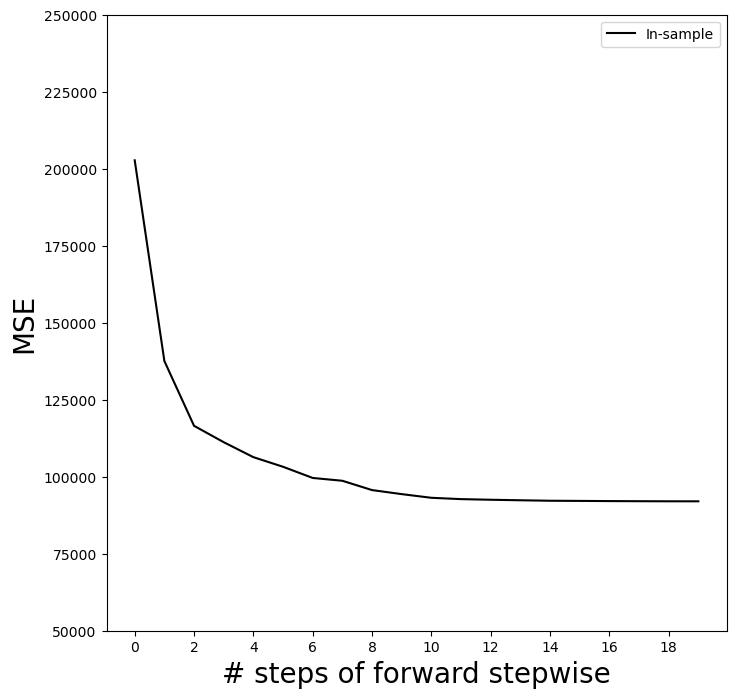

In [23]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000,250000]);

As expected, the in-sample MSE improves each step we take, indicating that we must either use the validation or cross-validation approach to select the number of steps.

We now use cross-validation to estimate test error along the model path. We must use only the training observations to perform all aspects of model-ftting — including variable selection. Therefore, the determination of which model of a given size is best must be made using
only the training observations in each training fold. This point is subtle but important. If the full data set is used to select the best subset at each step, then the validation set errors and cross-validation errors that we obtain will not be accurate estimates of the test error.

We now compute the cross-validated predicted values using 5-fold cross-validation:

In [24]:
K=5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path, Hitters, Y, cv=kfold)
Yhat_cv.shape

(263, 20)

At each model along the path, we compute the MSE in each of the cross-validation folds. We then average these to get the mean MSE, and can use the individual values to make a crude estimate of the standard error on the mean (crude because the five error estimates are based on overlapping training sets and are therefore not independent).

In [25]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

We add the cross-validation error estimates to our MSE plot (including error bars for the mean error across the five folds):

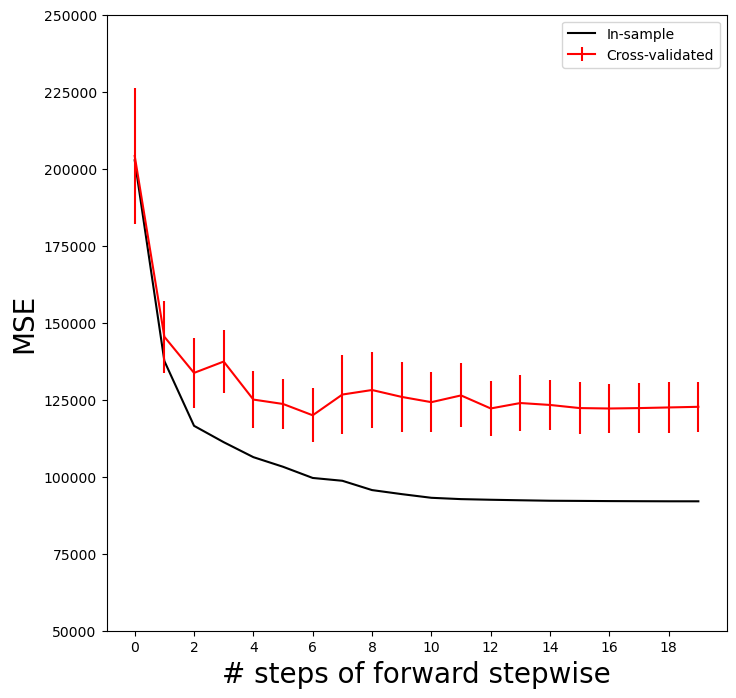

In [26]:
ax.errorbar(
    np.arange(n_steps),
    cv_mse.mean(1),
    cv_mse.std(1) / np.sqrt(K),
    label='Cross-validated',
    c='r'
) 
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

To repeat the above using the validation set approach, we simply change our cv argument to a validation set: one random split of the data into a test and training. We choose a test size of 20%, similar to the size of each test set in 5-fold cross-validation.

In [27]:
validation = skm.ShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=0
)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx],
    Y[train_idx])
Yhat_val = full_path.predict(Hitters.iloc[test_idx])
errors = (Yhat_val - Y[test_idx,None])**2
validation_mse = errors.mean(0)

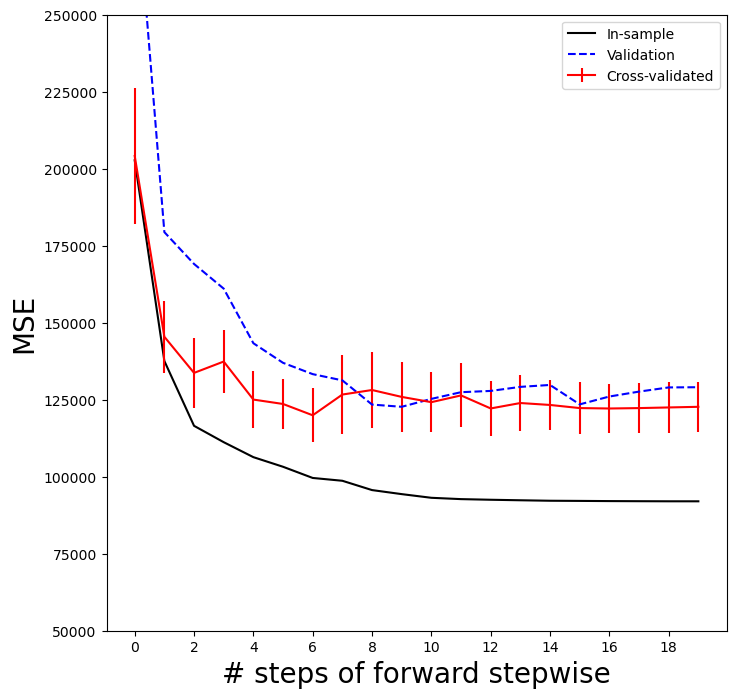

In [28]:
ax.plot(
    np.arange(n_steps),
    validation_mse,
    'b--',
    label='Validation'
)
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

#### Best subset selection

We use the package `10bnb` to perform best subset selection. This package produces a path of solutions using the subset size as a penalty rather than a constraint.

In [29]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

`fit_path()` returns a list whose balues include the fitted coefficients as `B`, an intercept `B0`, and some other attributes.

In [30]:
path = fit_path(X, Y, max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


In [32]:
path[3]

{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555494,
 'lambda_0': 0.011416248027450194,
 'M': 0.5829861733382014,
 'Time_exceeded': False}

### Ridge Regression and the Lasso

We use the `sklearn.linear_model` package to fit ridge and lasso regularised models on the `Hitters` data.

#### Ridge regression

We use the function `skl.ElasticNet()` to fit ridge and lasso. It is good practice to standardise the columns of `X` if the variables are measured in different units. Since `skl.ElasticNet()` does no normalisation, we take care of this ourselves. We must be careful to _unstandardise_ the coefficient estimates that we get.

In [ ]:
# Ridge regression corresponds to l1_ratio=0.
# The λ parameter is called alphas in sklearn.
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs, Y, l1_ratio=0., alphas=lambdas)[1] soln_array.shape